In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
import exoplanet as xo
import pymc3 as pm
import theano.tensor as tt
import warnings

In [2]:
# Remove when Theano is updated
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams["savefig.dpi"] = 150
plt.rcParams["figure.dpi"] = 150
plt.rcParams["font.size"] = 16
plt.rcParams['font.sans-serif'] = ['Arial']

# Download the Data

In [4]:
KIC = 4544587
lit_period = 2.189094
lit_t0 = 2455462.006137 - 2454833

Retrieve all the existing short-cadence photometry on this system. 

In [5]:
lcfs = lk.search_lightcurvefile("KIC %s"%KIC, mission="Kepler", cadence="short").download_all()
lc = lcfs.SAP_FLUX.stitch().remove_nans().remove_outliers(sigma = 3, sigma_lower = float('inf'))

/Users/mbadenas/opt/anaconda3/envs/mit37_mkl/lib/python3.7/site-packages/lightkurve/lightcurvefile.py:47: LightkurveWarning: `LightCurveFile.header` is deprecated, please use `LightCurveFile.get_header()` instead.
  LightkurveWarning)


Use a subset of the data (for now) 

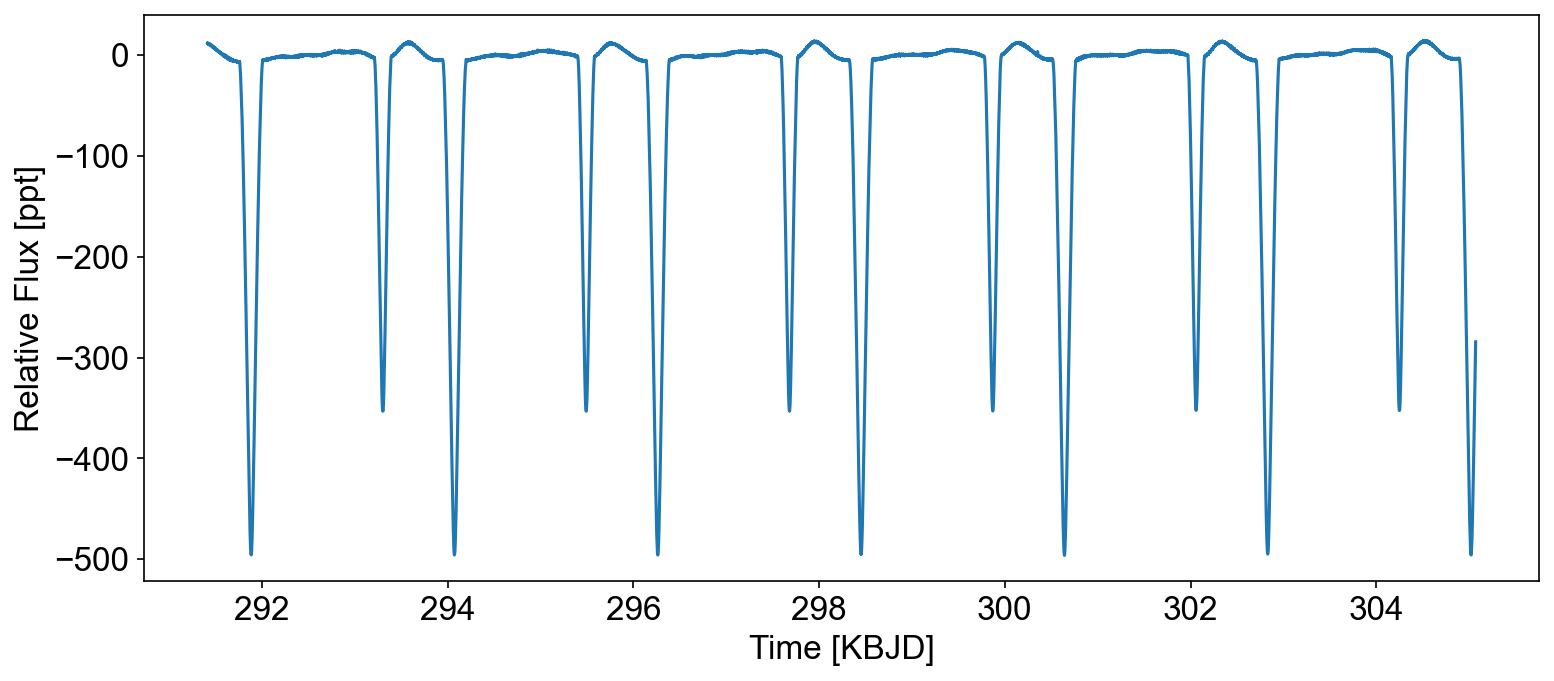

In [6]:
x = np.ascontiguousarray(lc.time[:20000], dtype=np.float64)
y = np.ascontiguousarray(lc.flux[:20000], dtype=np.float64)
mu = np.median(y)
y = (y / mu - 1) * 1e3

fig, ax = plt.subplots(1,1)
ax.plot(x,y) 
ax.set(xlabel = 'Time [KBJD]', ylabel = 'Relative Flux [ppt]');

Phase-fold the light curve

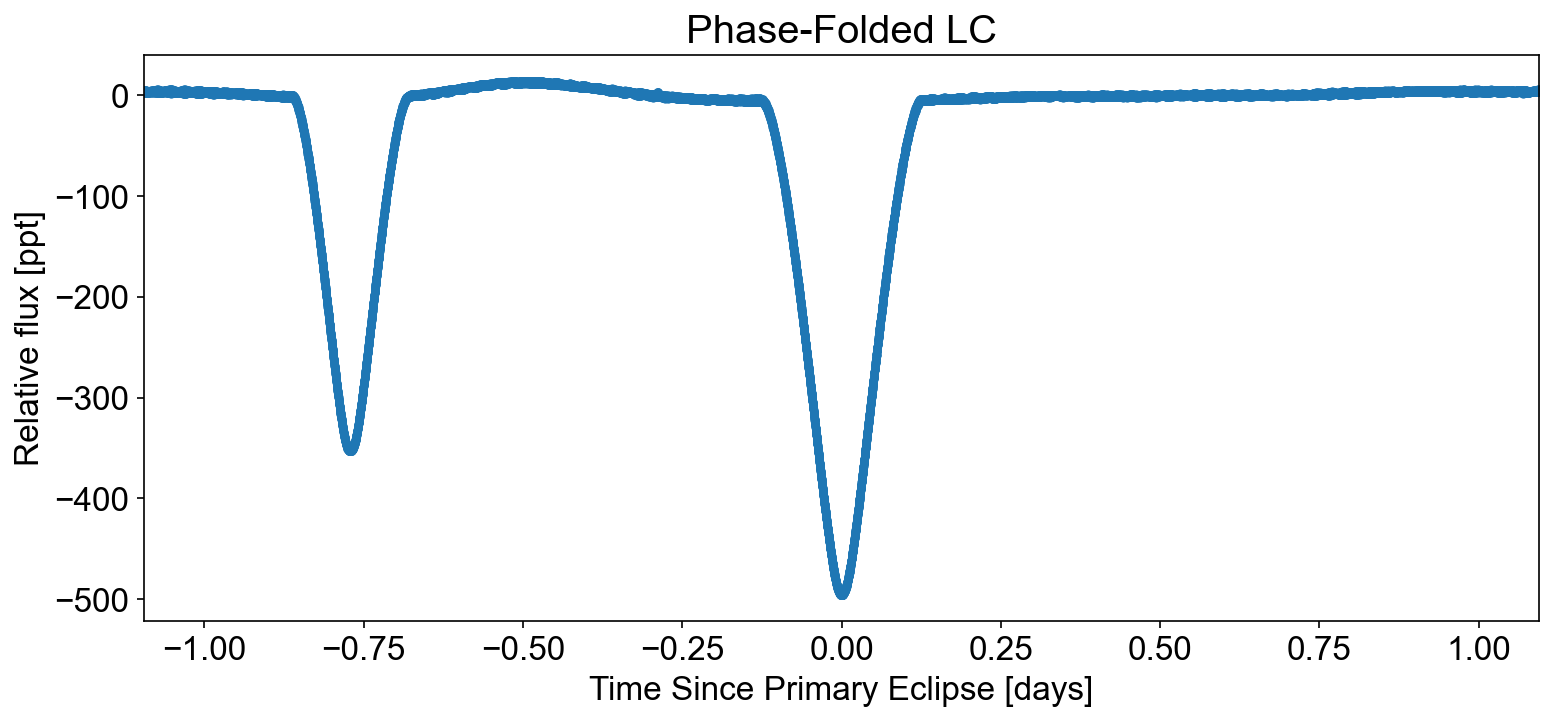

In [16]:
x_fold = (x - lit_t0 + 0.5 * lit_period) % lit_period - 0.5 * lit_period
    
fig, ax = plt.subplots(1,1)
ax.plot(x_fold, y, '.')
ax.set(
    xlim = (-0.5 * lit_period, 0.5 * lit_period), 
    xlabel = "Time Since Primary Eclipse [days]",
    ylabel = "Relative flux [ppt]",
    title = "Phase-Folded LC"
);

# Estimate the Phase Curve

In [17]:
bin_edges = lit_period * np.linspace(-0.5, 0.5, 5000)
num, _ = np.histogram(x_fold, bin_edges, weights=y)
denom, _ = np.histogram(x_fold, bin_edges)

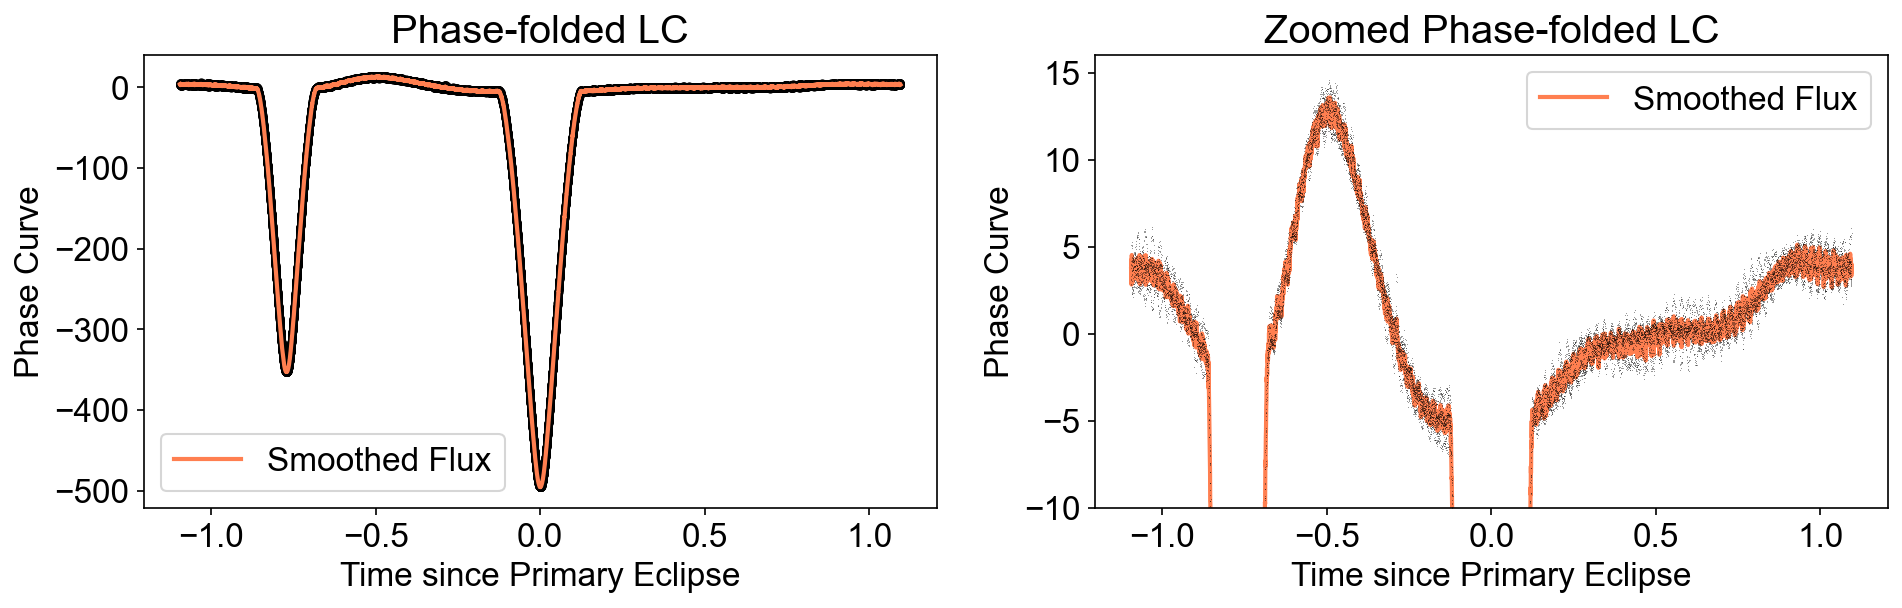

In [18]:
x_smooth = 0.5 * (bin_edges[1:] + bin_edges[:-1])
y_smooth = num / denom
m = np.abs(x_smooth) > 0.5
second_phase = x_smooth[m][np.argmin(y_smooth[m])]

x_smooth = np.concatenate(([2 * x_smooth[0] - x_smooth[1]], x_smooth, [2 * x_smooth[-1] - x_smooth[-2]]))
y_smooth = np.concatenate(([y_smooth[-1]], y_smooth, [y_smooth[0]]))

fig, ax = plt.subplots(1,2, sharex=True, figsize=(15,4))
fig.subplots_adjust(hspace=0.1)
ax[0].plot(x_fold,y, '.k')
ax[0].plot(x_smooth, y_smooth, lw = 2, c = 'coral', label = 'Smoothed Flux');
ax[0].legend()
ax[0].set(xlabel = "Time since Primary Eclipse", ylabel="Phase Curve", title = 'Phase-folded LC');
ax[1].plot(x_smooth, y_smooth, lw = 2, c = 'coral', label = 'Smoothed Flux');
ax[1].plot(x_fold,y, ',k', alpha = 0.4)
ax[1].set(xlabel = "Time since Primary Eclipse", ylabel="Phase Curve", title = 'Zoomed Phase-folded LC', ylim=(-10,16));
ax[1].legend()
plt.pause(0.05); plt.close("all")

mod = np.interp(x_fold, x_smooth, y_smooth) 

##### Compute the out-of-eclipse residuals away from this phase curve
mask = (np.abs(x_fold - second_phase) > 0.2) & (np.abs(x_fold) > 0.2)
resid = y - mod
sigma = np.median(resid[mask] ** 2)
mask[mask] &= np.abs(resid[mask]) < 20 * sigma

# Find 1st Batch of Oscillation Frequencies

In [19]:
def min2day(m): return m*6.944*(10**-4)
def hour2day(h): return h*0.04167

def freq2dhms(f): 
    if len(f)>1: 
        for freq in f:
            d = 1./freq
            print("f = %0.02f 1/d --> %0.04f days, %0.02f hours, %0.02f min, %0.02f sec" %(freq, d, d*24, d*24.*60., d*24.*60.*60))
    else:
        d = 1./f
        print("f = %0.02f 1/d --> %0.04f days, %0.02f hours, %0.02f min, %0.02f sec" %(f, d, d*24, d*24.*60., d*24.*60.*60))
        
def find_oscillations(time, flux, npeaks, minP, maxP):
    res_ls = xo.estimators.lomb_scargle_estimator(
        time, 
        flux, 
        max_peaks=npeaks, 
        min_period=1.0/maxP, 
        max_period=1.0/minP
    )

    # Hack to remove nearby modes
    peak_freq = np.array([1.0/res_ls["peaks"][0]["period"]])
    peak_log_power = [res_ls["peaks"][0]["log_power"]]
    
    for peak in res_ls["peaks"][1:]:
        freq = 1.0 / peak["period"]
        if np.any(np.abs(peak_freq - freq) < 0.2):
            continue
        peak_freq = np.append(peak_freq, freq)
        peak_log_power.append(peak["log_power"])

    print(f"Found {len(peak_freq)} frequencies")
    
    freq2dhms(peak_freq)
    
    fig, ax = plt.subplots(1,1,figsize=(12,5))
    freq, power = res_ls["periodogram"]
    ax.plot(freq, power, color="grey")
    ax.plot(peak_freq, np.exp(peak_log_power), "or")
    ax.set(xlabel="Frequency [1/day]", ylabel = "Power");
    plt.pause(0.05); plt.close("all")
    
    return res_ls, peak_freq, np.exp(peak_log_power)

Let's find the most dominant frequencies. We'll use them to initialize the model below. 

Found 10 frequencies
f = 48.03 1/d --> 0.0208 days, 0.50 hours, 29.98 min, 1798.85 sec
f = 41.37 1/d --> 0.0242 days, 0.58 hours, 34.81 min, 2088.62 sec
f = 46.21 1/d --> 0.0216 days, 0.52 hours, 31.16 min, 1869.76 sec
f = 47.12 1/d --> 0.0212 days, 0.51 hours, 30.56 min, 1833.65 sec
f = 39.55 1/d --> 0.0253 days, 0.61 hours, 36.41 min, 2184.40 sec
f = 44.85 1/d --> 0.0223 days, 0.54 hours, 32.11 min, 1926.37 sec
f = 47.59 1/d --> 0.0210 days, 0.50 hours, 30.26 min, 1815.42 sec
f = 40.46 1/d --> 0.0247 days, 0.59 hours, 35.59 min, 2135.30 sec
f = 38.22 1/d --> 0.0262 days, 0.63 hours, 37.68 min, 2260.68 sec
f = 49.40 1/d --> 0.0202 days, 0.49 hours, 29.15 min, 1748.96 sec


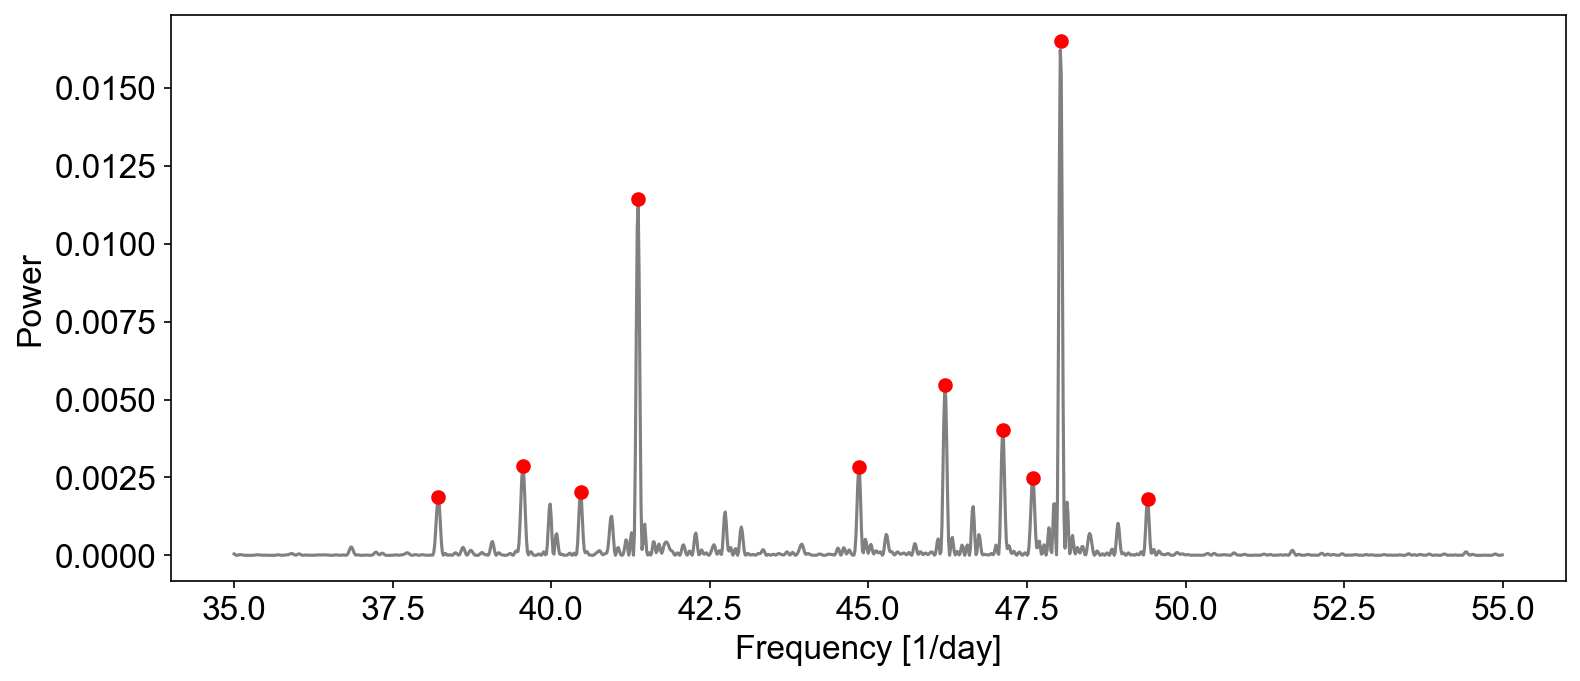

In [20]:
_, freq_osc_0, power_osc_0 = find_oscillations(x[mask], resid[mask], 10, 35, 55)

# Define the Model 

In [21]:
def build_model(time, flux, mask, osc_freqs):
    with pm.Model() as model:
        
        # Systemic parameters
        u1 = xo.QuadLimbDark("u1")
        u2 = xo.QuadLimbDark("u2")

        # Parameters describing the primary: could include priors based on isochrones or similar
        M1 = pm.Lognormal("M1", mu=0.0, sigma=10.0)
        R1 = pm.Lognormal("R1", mu=0.0, sigma=10.0)

        # Secondary ratios
        k = pm.Lognormal("k", mu=0.0, sigma=10.0)  # radius ratio R2/R1
        q = pm.Lognormal("q", mu=0.810, sigma=0.01)  # mass ratio M2/M1
        s = pm.Lognormal("s", mu=np.log(0.5), sigma=10.0)  # surface brightness ratio S2/S1

        # Parameters describing the orbit
        b = xo.ImpactParameter("b", ror=k, testval=1.5)
        period = pm.Lognormal("period", mu=np.log(lit_period), sigma=1.0)
        t0 = pm.Normal("t0", mu=lit_t0, sigma=1.0)

        # Parameters describing the eccentricity: ecs = [e * cos(w), e * sin(w)]
        ecosw = 0.25 * np.pi * (2 * (second_phase + lit_period) / lit_period - 1)
        ecs = xo.UnitDisk("ecs", testval=np.array([ecosw, 0.0]))
        ecc = pm.Deterministic("ecc", tt.sqrt(tt.sum(ecs ** 2)))
        omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))

        # Build the orbit
        R2 = pm.Deterministic("R2", k * R1)
        M2 = pm.Deterministic("M2", q * M1)
        orbit = xo.orbits.KeplerianOrbit(
            period=period,
            t0=t0,
            ecc=ecc,
            omega=omega,
            b=b,
            r_star=R1,
            m_star=M1,
            m_planet=M2,
        )

        # Track some other orbital elements
        pm.Deterministic("incl", orbit.incl)
        pm.Deterministic("a", orbit.a)
        
        # Set up the light curve model
        lc = xo.SecondaryEclipseLightCurve(u1, u2, s)
        model_lc = 1e3 * lc.get_light_curve(orbit=orbit, r=R2, t=time[mask])[:, 0]

        # Oscillation model using frequencies determined above
        arg = osc_freqs[None, :] * time[mask, None]
        X = np.concatenate([np.cos(2 * np.pi * arg), np.sin(2 * np.pi * arg),], axis=1)
        
#         w0 = np.linalg.lstsq(X, y[mask])[0]
#         w = pm.Normal("w", mu=0.0, sigma=10.0, shape=len(w0), testval=w0)
#         osc = tt.dot(X, w)
#         osc = tt.zeros(mask.sum())
        
        # Phase curve: mixture of harmonics of the period. 6th order seems to work well based on trial and error
        phi = ((time[mask] - t0) / period) % 1.0
        n_expand = 6
        comps = tt.stack([
            tt.sin(2 * (n + 1) * np.pi * phi)
            for n in range(n_expand)
        ] + [
            tt.cos(2 * (n + 1) * np.pi * phi)
            for n in range(n_expand)
        ], axis=1)
#        amps = pm.Normal("amps", sigma=100.0, shape=2 * n_expand)
#        phase_curve = tt.dot(amps, comps)
        
        # Noise model for the light curve
        sigma_lc = pm.InverseGamma("sigma_lc", testval=1.0, **xo.estimate_inverse_gamma_parameters(0.1, 2.0))
        S_tot_lc = pm.InverseGamma("S_tot_lc", testval=2.5, **xo.estimate_inverse_gamma_parameters(1.0, 5.0))
        ell_lc = pm.InverseGamma("ell_lc", testval=2.0, **xo.estimate_inverse_gamma_parameters(1.0, 5.0))
        kernel_lc = xo.gp.terms.SHOTerm(S_tot=S_tot_lc, w0=2 * np.pi / ell_lc, Q=1.0/3) 
         
#       def mean_model(t):
#           return mean_lc + osc + phase_curve + model_lc(t)
        
        gp_lc = xo.gp.GP(kernel_lc, time[mask], tt.zeros(mask.sum()) ** 2 + sigma_lc ** 2)
        
        D = tt.concatenate((X, comps, tt.ones((mask.sum(), 1))), axis=1)
        DT = D.T
        DTD = tt.dot(DT, gp_lc.apply_inverse(DT.T)) + 0.01**2 * tt.eye(2 * (len(osc_freqs) + n_expand) + 1)
        
        DTD_det_print = tt.printing.Print("DTD_det")(tt.nlinalg.det(DTD))
        
        DTy = tt.dot(DT, gp_lc.apply_inverse((flux[mask] - model_lc)[:, None]))
        factor = tt.slinalg.cholesky(DTD)
        weights = tt.slinalg.solve_upper_triangular(factor.T, tt.slinalg.solve_lower_triangular(factor, DTy))[:, 0]
        #weights = tt.slinalg.solve(DTD, DTy)[:, 0]
        w = pm.Deterministic("w", weights[:2 * len(osc_freqs)])
        osc = tt.dot(X, w)
        amps = pm.Deterministic("amps", weights[2 * len(osc_freqs):2 * n_expand + 2 *len(osc_freqs)])
        phase_curve = tt.dot(comps, amps)
        mean_lc = pm.Deterministic("mean_lc", weights[-1])
        
#       # Condition the light curve model on the data
#         gp_lc = xo.gp.GP(
#             kernel_lc, x[mask], tt.zeros(mask.sum()) ** 2 + sigma_lc ** 2, mean=mean_model
#         )
        gp_lc.marginal("obs_lc", observed=flux[mask] - tt.dot(D, weights) - model_lc)

        # Optimize the logp
        map_soln = model.test_point
        map_soln = xo.optimize(map_soln, [R1, k, s, b, u1, u2])
        #map_soln = xo.optimize(map_soln, [amps])
        #map_soln = xo.optimize(map_soln, [w])
        map_soln = xo.optimize(map_soln, [sigma_lc, S_tot_lc, ell_lc])
        map_soln = xo.optimize(map_soln)

        model.osc = osc
        model.phase_curve = phase_curve
        model.gp_lc = gp_lc
        model.model_lc = model_lc
        model.x = time[mask]
        model.y = flux[mask]

    return model, map_soln

In [22]:
cdict = {"lc": 'lightsteelblue', "gp_pred": "orange", "pc": "green", "osc": "crimson"}
args = dict(lw=2)
    
def get_MAP(flux, best_model, map_solution, i,plot_bool):
    
    with best_model:
        gp_pred = xo.eval_in_model(best_model.gp_lc.predict(), map_solution) + map_solution["mean_lc"]
        lc = xo.eval_in_model(best_model.model_lc, map_solution)
        osc, pc = xo.eval_in_model([best_model.osc, best_model.phase_curve], map_solution)
        
    model_residuals = flux - lc - pc - osc - gp_pred
    
    if plot_bool == True:
        #Plot Osc, PC, and GP models
        fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(12, 12))
        fig.subplots_adjust(hspace=0.1)

        ax1.plot(best_model.x, best_model.y, "k.", alpha=0.2, label = 'Observed LC')
        ax1.plot(best_model.x, lc, c=cdict["lc"], **args, label = 'Eclipse Model')
        ax1.plot(best_model.x, gp_pred, c=cdict["gp_pred"], **args, label = 'GP Model')
        ax1.legend(fontsize=12)
        ax1.set(ylabel="Raw flux [ppt]", title = "MAP model");

        ax2.plot(best_model.x, best_model.y, "k.", alpha=0.2, label = 'Observed LC')
        ax2.plot(best_model.x, osc, c=cdict["osc"], **args, label = 'Oscillations Model')
        ax2.plot(best_model.x, pc, c=cdict["pc"], **args, label = 'Phase Curve Model')
        ax2.legend(fontsize=12)
        ax2.set(xlim = (best_model.x.min(), best_model.x.max()), ylim = (-10, 15), ylabel="Raw flux [ppt]");

        ax3.plot(best_model.x, best_model.y - lc - pc - gp_pred, "k.", alpha=0.2, 
                 label = 'Observed LC - (Eclipse Model + Phase Curve Model + GP. Model)') #
        ax3.plot(best_model.x, osc, c=cdict["osc"], lw=1, label = "Oscillations Model")
        ax3.legend(fontsize=12)
        ax3.set(ylabel="Eclipse + Phase removed [ppt]", xlabel = "Time [KBJD]");
        
        fig.savefig("map_model_"+i+".png")
        #other plots for visualization
        #fig, ax = plt.subplots(1, figsize=(12, 3.5))
        #ax.plot(best_model.x, flux, "k.", label = 'Observed Flux')
        #ax.plot(best_model.x, flux - osc, c="wheat", label = 'Observed Flux - Oscillation Model')
        #ax.plot(best_model.x, flux - osc - pc - gp_pred , c="yellowgreen", label = 'Observed Flux - (Osc. + PC + GP)')
        #ax.plot(best_model.x, flux - osc - gp_pred , label = 'Observed Flux - (Osc. + GP)')
        #ax.legend(fontsize=12)
        #ax.set(ylabel="Raw flux [ppt]", xlabel = "Time [KBJD]",  ylim = (-10, 15));
        
        #Detrended Flux: Observed LC - (GP + Osc)
        fig, ax1 = plt.subplots(1, figsize=(12, 3.5))
        x_fold = (best_model.x - map_solution["t0"]) % map_solution["period"] / map_solution["period"]
        inds = np.argsort(x_fold)

        ax1.plot(x_fold[inds], best_model.y[inds] - gp_pred[inds] - osc[inds], "k.", alpha=0.2)
        ax1.plot(x_fold[inds] - 1, best_model.y[inds] - gp_pred[inds] - osc[inds], "k.", alpha=0.2)
        ax1.plot(x_fold[inds], lc[inds], c = cdict["lc"], **args, label = "Eclipse Model")
        ax1.plot(x_fold[inds] - 1, lc[inds], c = cdict["lc"], **args)
        ax1.plot(x_fold[inds], pc[inds], c = cdict["pc"], **args)
        ax1.plot(x_fold[inds] - 1, pc[inds],c = cdict["pc"], **args, label = "Phase Curve Model")
        ax1.set(xlim=(-1, 1), ylabel = "De-trended flux [ppt]", xlabel = "Phase", title = "MAP model");
        ax1.legend(fontsize=12)
        fig.savefig("detrended_fux_"+i+".png")

        fig, (ax1,ax2) = plt.subplots(2,1, sharex = True, figsize=(16,10))
        ax1.plot(best_model.x, gp_pred, c=cdict["gp_pred"], label = 'GP Model')
        ax1.plot(best_model.x, pc, c=cdict["pc"], label = 'Phase Curve Model')
        ax1.plot(best_model.x, osc, c=cdict["osc"], label = 'Oscillation Model')
        ax1.set_ylabel('Flux [ppt]')
        ax1.legend(fontsize=12)

        ax2.plot(best_model.x, osc, c=cdict["osc"])
        ax2.plot(best_model.x, model_residuals, c='lightsteelblue', alpha = 0.8, label = 'Residuals = Observed LC - (LC Model + Osc. Model + PC Model + GP Model)')
        ax2.set(xlabel = "Time [KBJD]", ylabel="Flux Residuals [ppt]")
        ax2.legend(fontsize=12)
        fig.savefig("residuals_"+i+".png")

        plt.pause(0.05); plt.close("all")
    
    return model_residuals, lc, osc, pc, gp_pred


# Iterative Process to Search for New Oscillation Frequencies

In [ ]:
mask_iterative = np.ones(len(x), dtype=bool) #we won't call the sigma_clip function for now (still need to find a way to implement it)

In [ ]:
osc_models = {} #Store the MAP oscillation model in each iteration
detected_osc = {0: [freq_osc_0, power_osc_0]} #Store the freq & power of the detected oscillations in each iteration

In [ ]:
plot_bool = True # set to false if you don't want to see MAP model plots. 

               Iteration 1
--------------------------------------------
DTD_det __str__ = 3.681865040062822e+107


optimizing logp for variables: [u2, u1, b, k, s, R1]


message: Desired error not necessarily achieved due to precision loss.
logp: -9552857.259433204 -> -227254.56094528842
optimizing logp for variables: [ell_lc, S_tot_lc, sigma_lc]


message: Desired error not necessarily achieved due to precision loss.
logp: -227254.56094528842 -> -1585.9121804572173
optimizing logp for variables: [ell_lc, S_tot_lc, sigma_lc, ecs, t0, period, b, s, q, k, R1, M1, u2, u1]


message: Desired error not necessarily achieved due to precision loss.
logp: -1585.9121804572173 -> 842.3215881613435


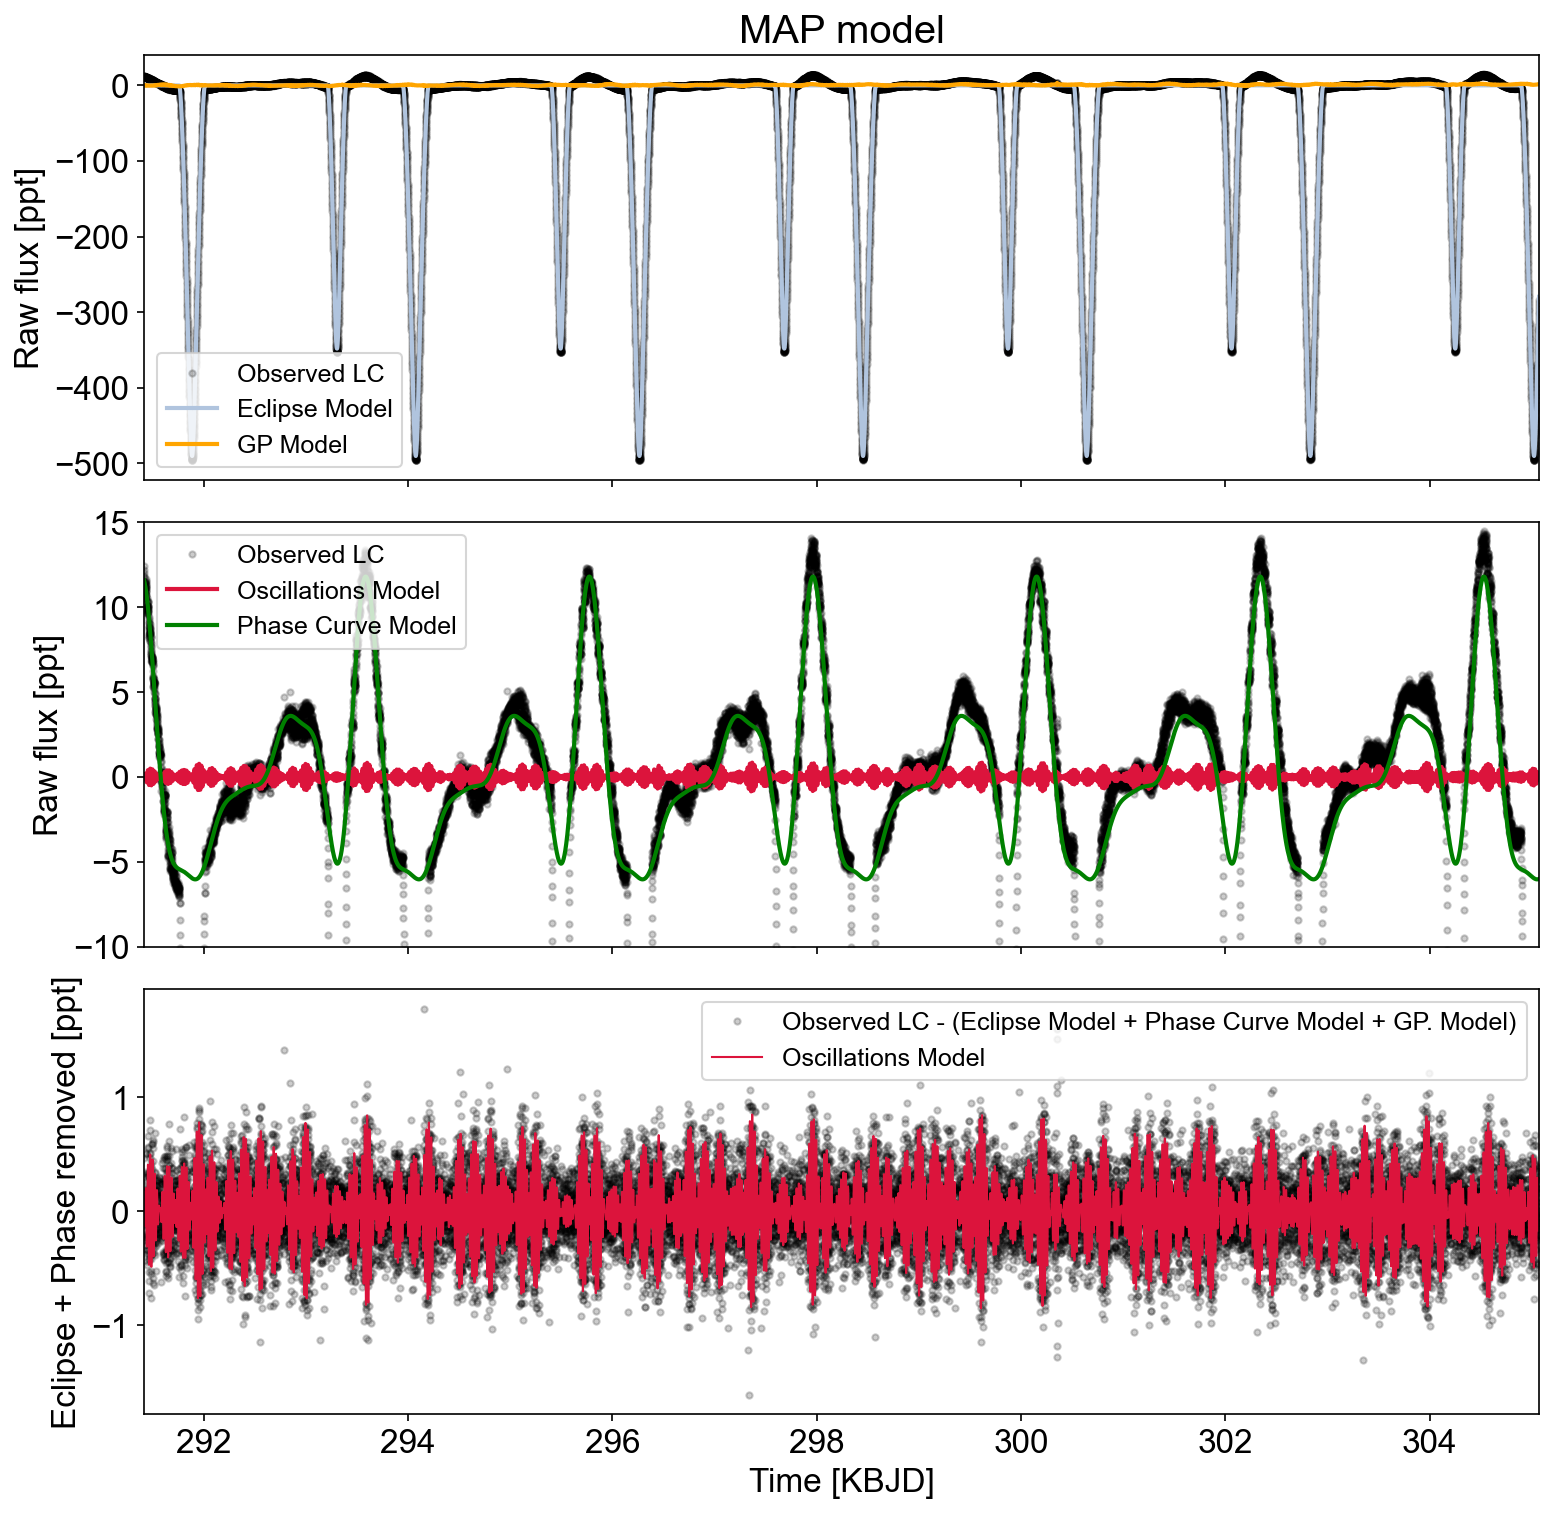

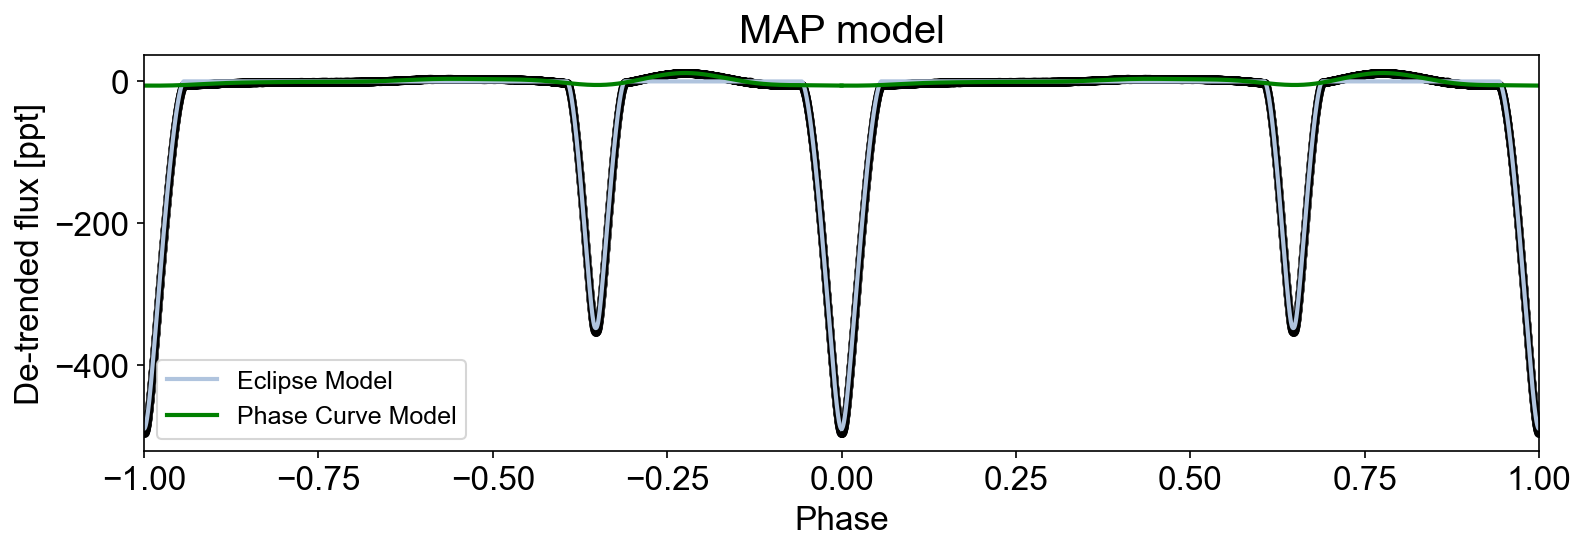

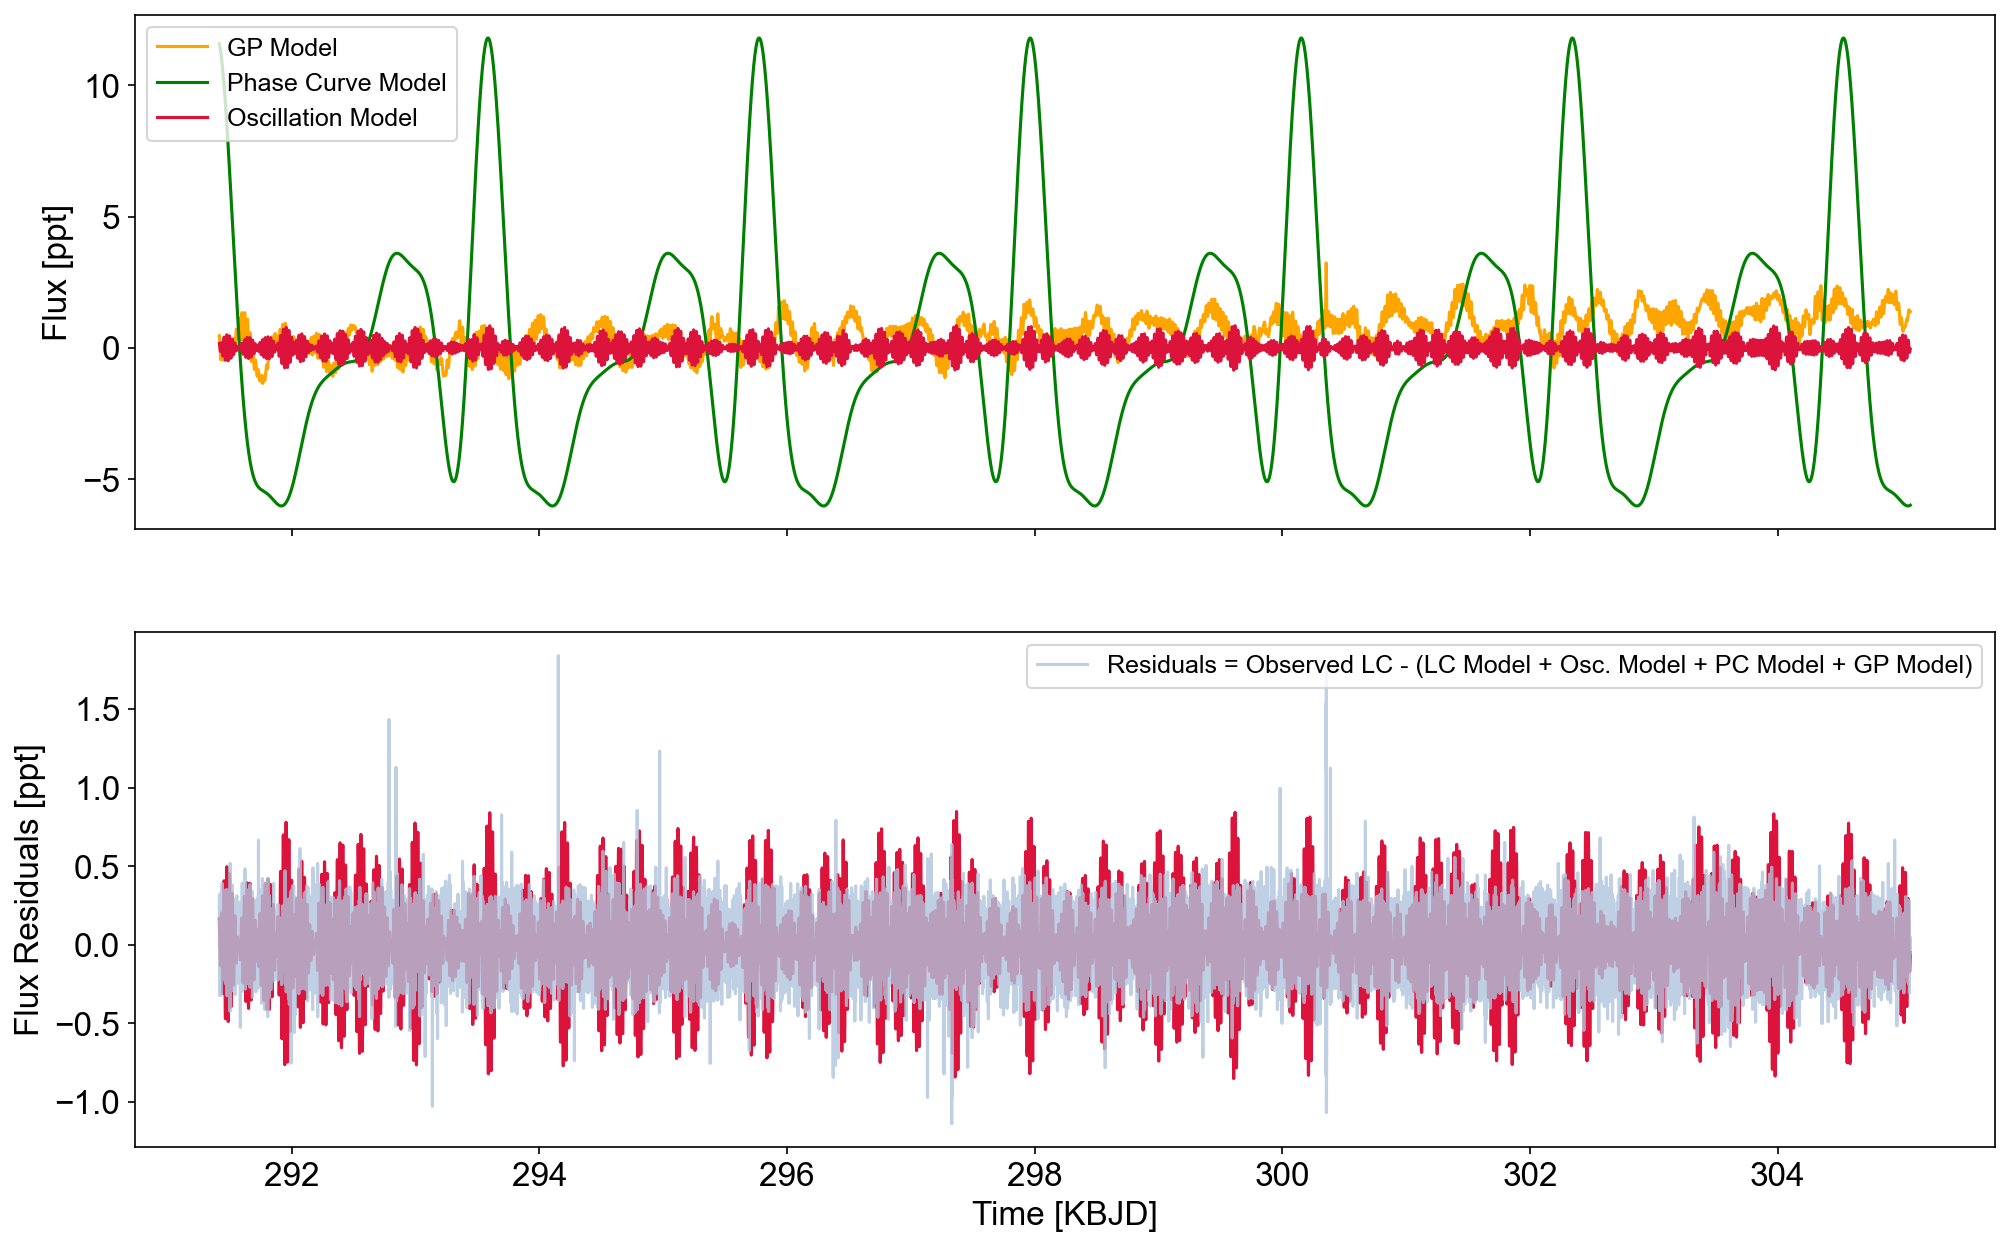

Found 4 frequencies
f = 44.31 1/d --> 0.0226 days, 0.54 hours, 32.50 min, 1949.81 sec
f = 47.97 1/d --> 0.0208 days, 0.50 hours, 30.02 min, 1800.96 sec
f = 46.58 1/d --> 0.0215 days, 0.52 hours, 30.91 min, 1854.87 sec
f = 44.78 1/d --> 0.0223 days, 0.54 hours, 32.16 min, 1929.48 sec


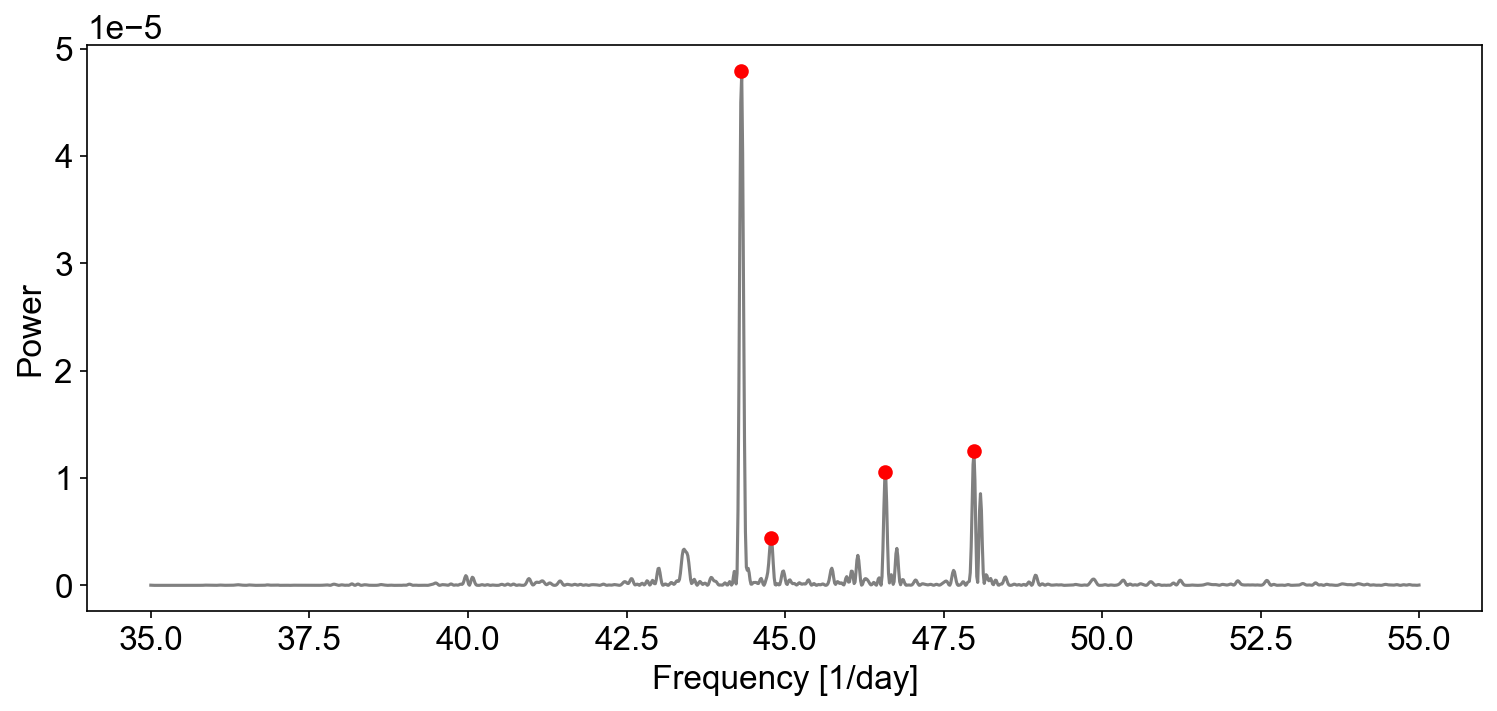

               Iteration 2
--------------------------------------------
DTD_det __str__ = 3.0702161920147883e+139


optimizing logp for variables: [u2, u1, b, k, s, R1]


message: Desired error not necessarily achieved due to precision loss.
logp: -9552549.231769498 -> -227049.80213321742
optimizing logp for variables: [ell_lc, S_tot_lc, sigma_lc]


message: Desired error not necessarily achieved due to precision loss.
logp: -227049.80213321742 -> -1457.1646907778443
optimizing logp for variables: [ell_lc, S_tot_lc, sigma_lc, ecs, t0, period, b, s, q, k, R1, M1, u2, u1]


message: Desired error not necessarily achieved due to precision loss.
logp: -1457.1646907778443 -> 1652.2994536894055


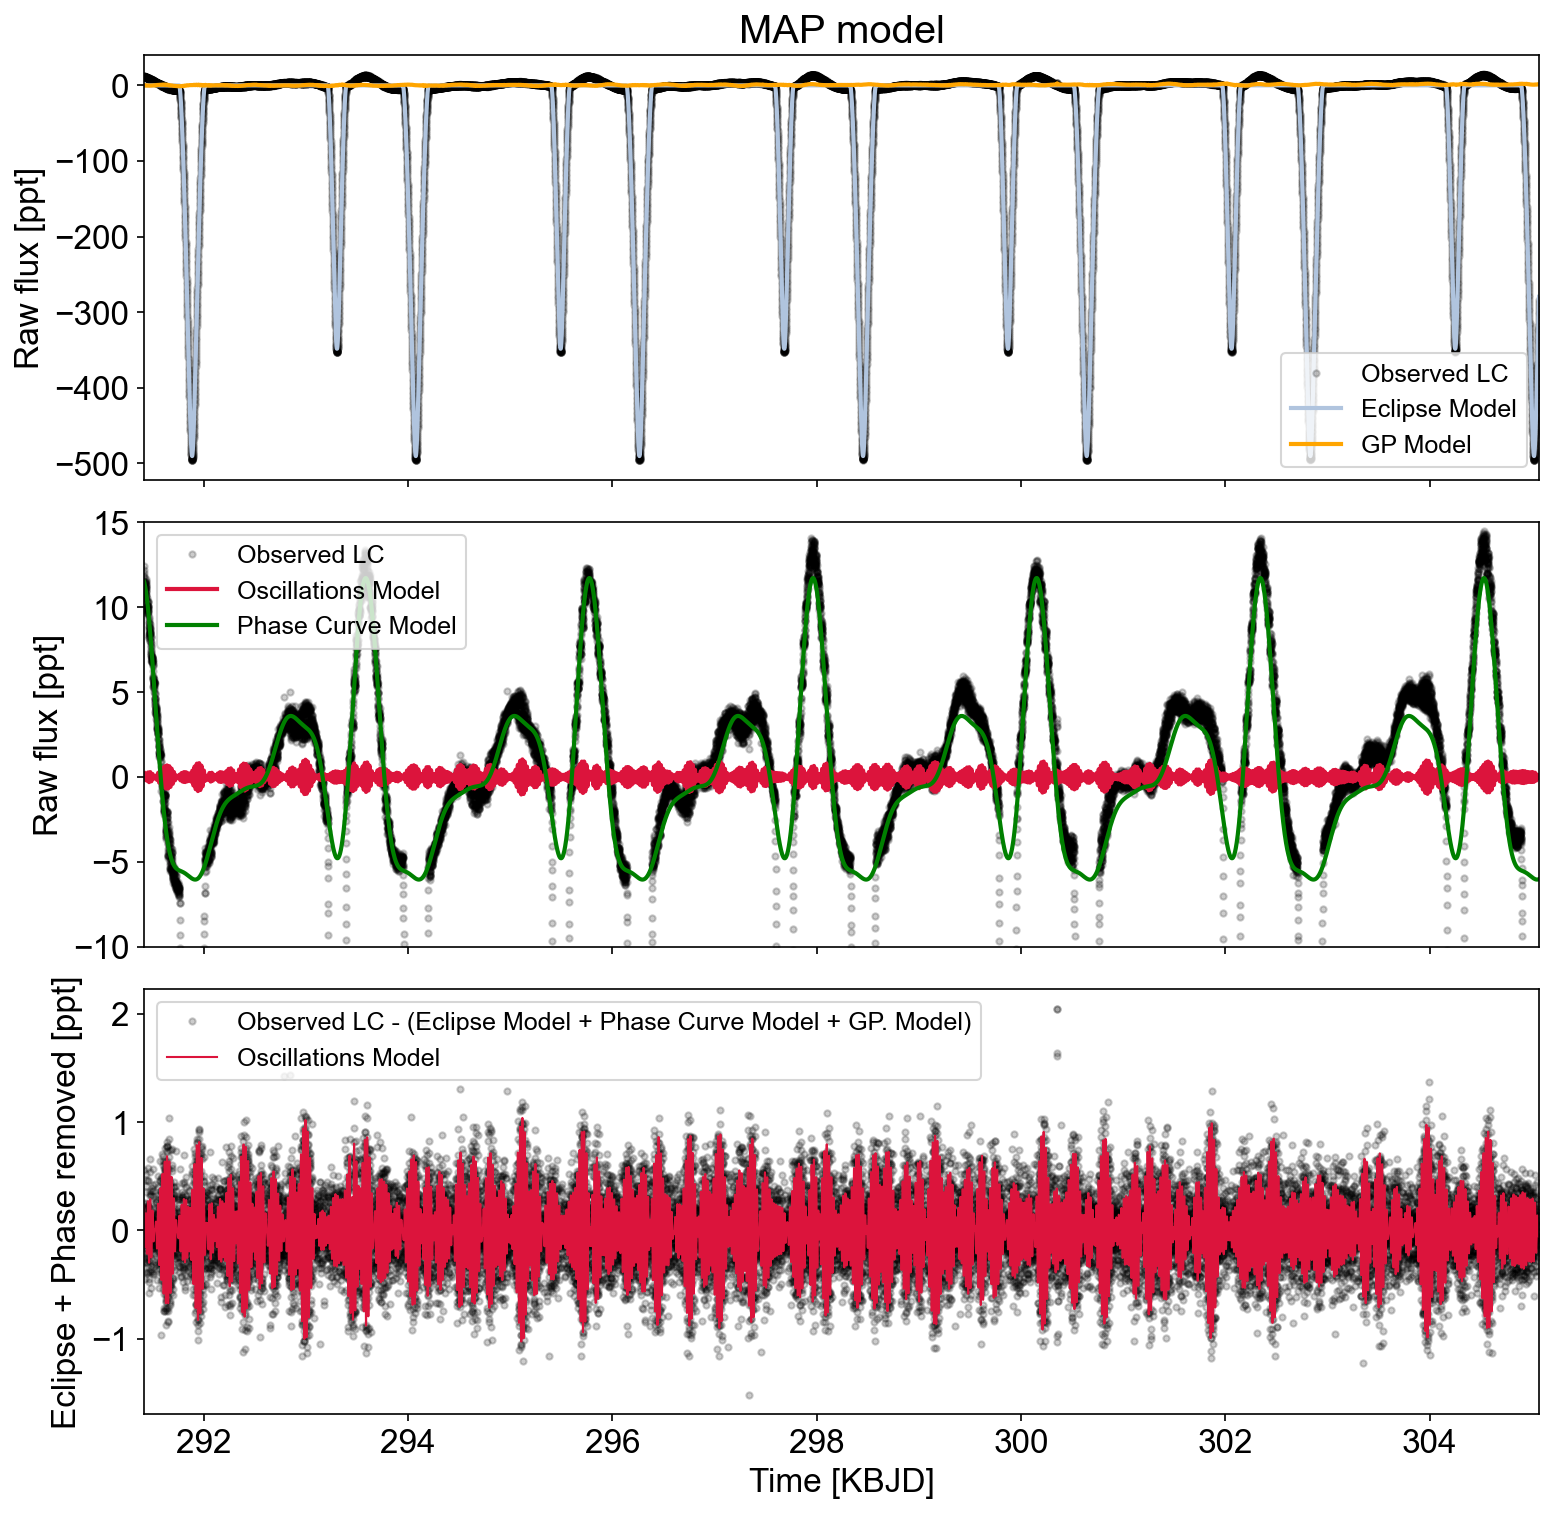

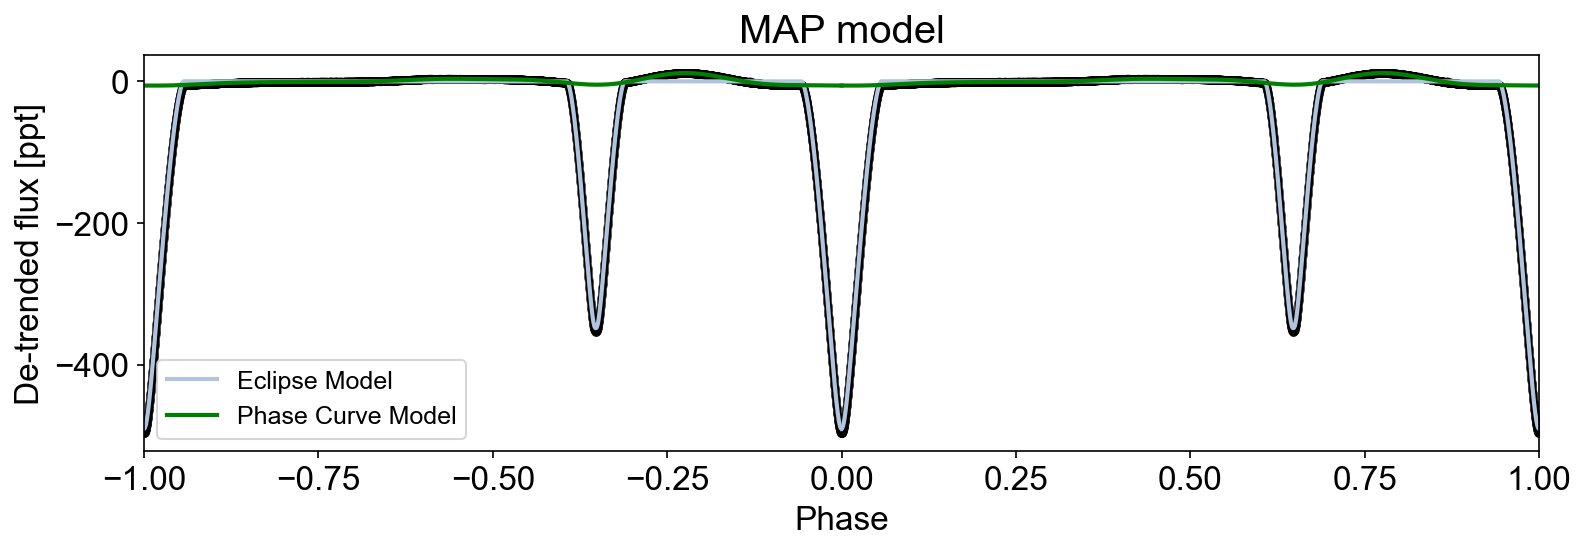

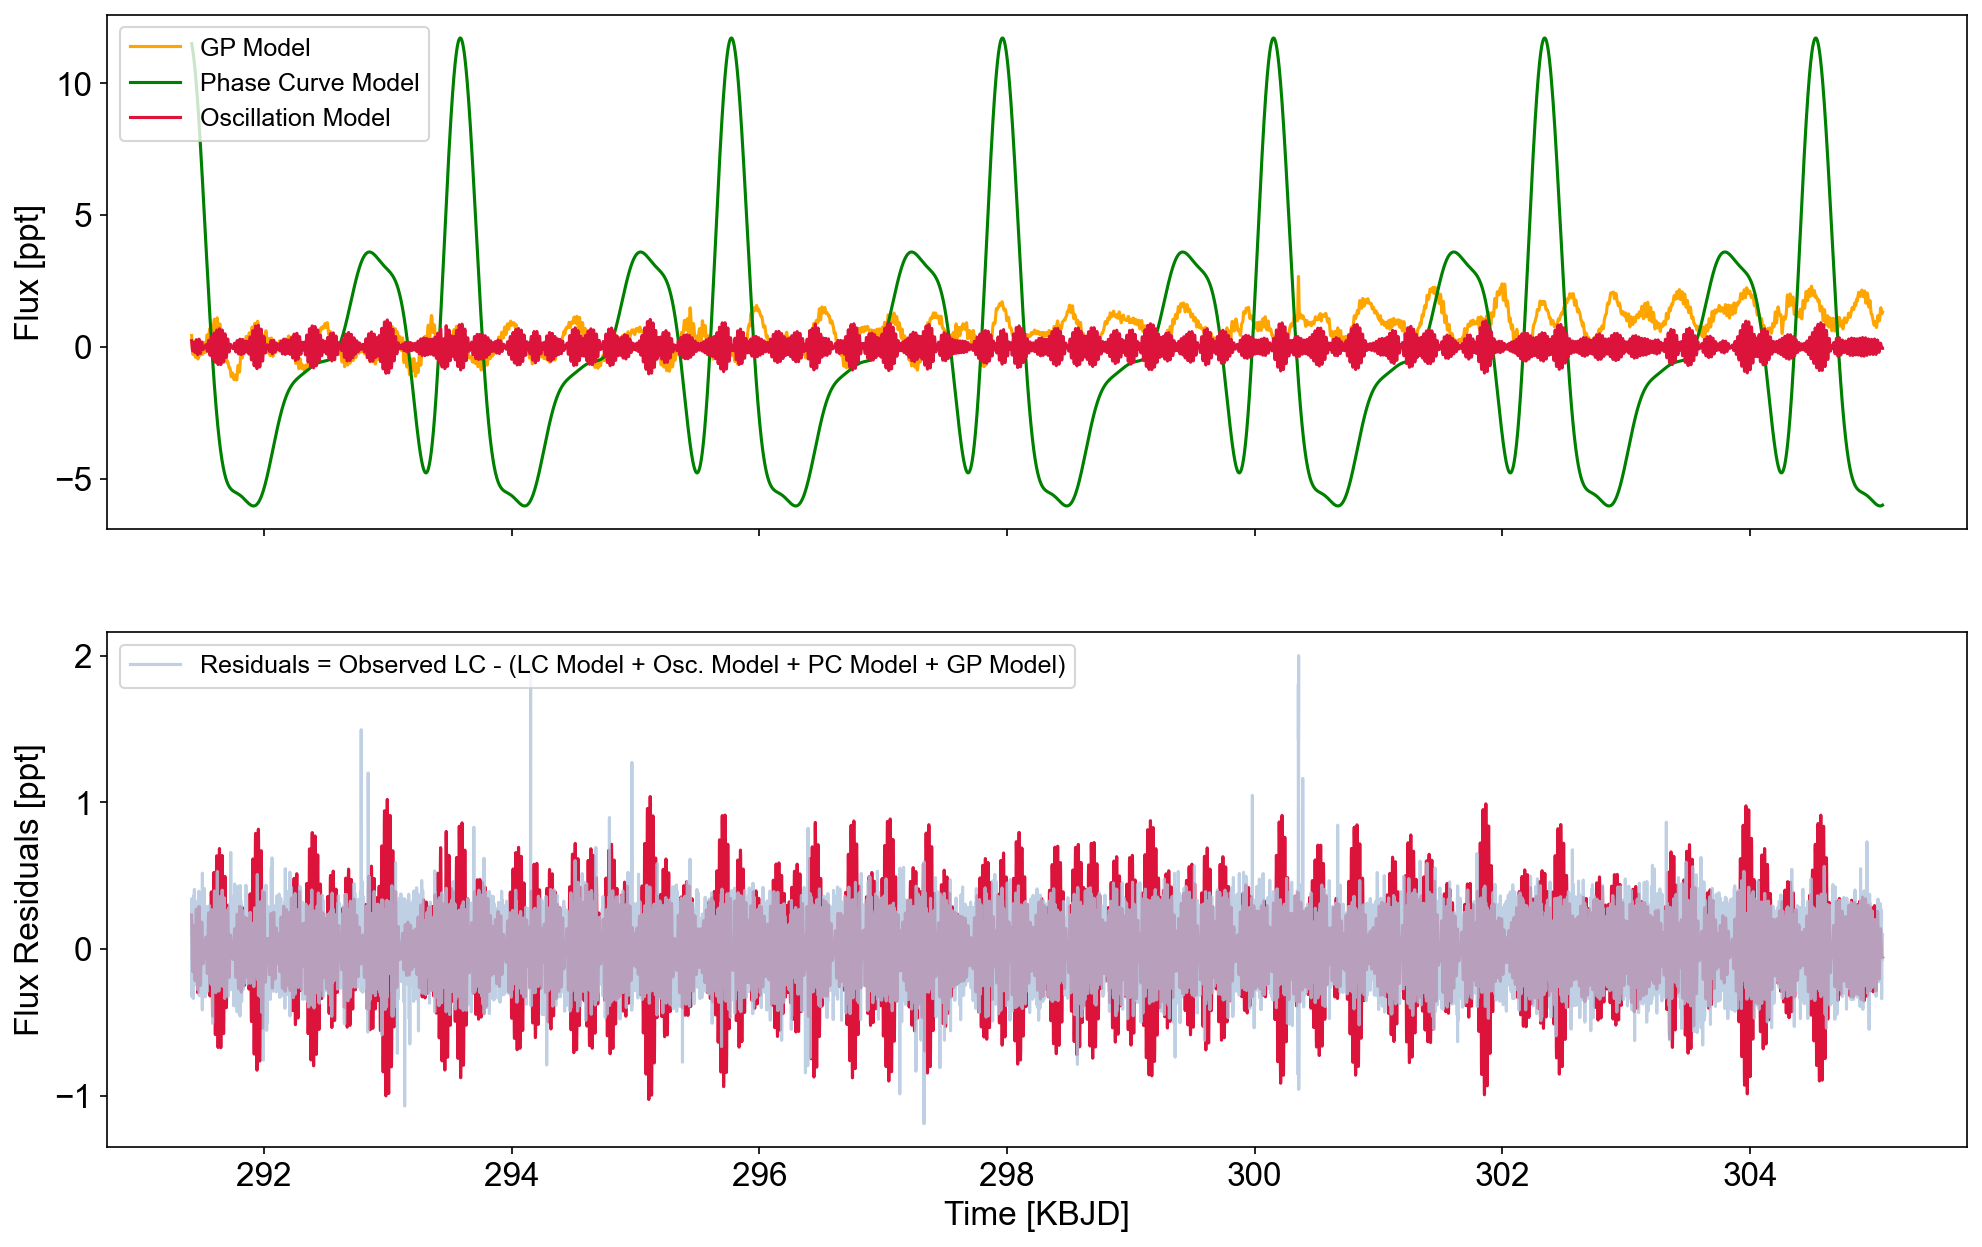

Found 4 frequencies
f = 43.45 1/d --> 0.0230 days, 0.55 hours, 33.14 min, 1988.31 sec
f = 48.10 1/d --> 0.0208 days, 0.50 hours, 29.94 min, 1796.44 sec
f = 46.15 1/d --> 0.0217 days, 0.52 hours, 31.20 min, 1872.00 sec
f = 46.76 1/d --> 0.0214 days, 0.51 hours, 30.79 min, 1847.68 sec


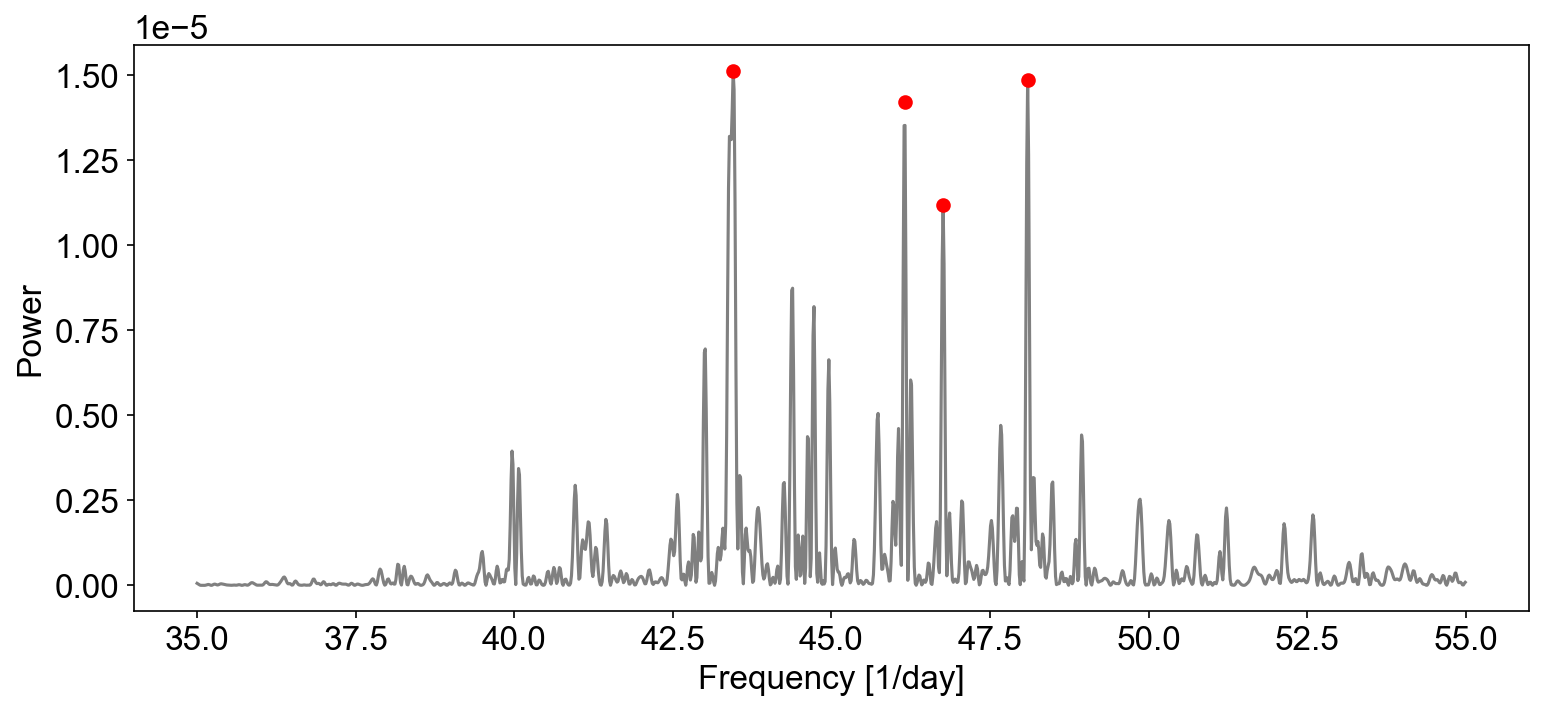

               Iteration 3
--------------------------------------------
DTD_det __str__ = 2.1013285187897904e+171


optimizing logp for variables: [u2, u1, b, k, s, R1]


message: Desired error not necessarily achieved due to precision loss.
logp: -9552488.38405942 -> -227007.91237745702
optimizing logp for variables: [ell_lc, S_tot_lc, sigma_lc]


array: [ 9.83829174 33.53297475 -2.30968558]
point: {'u1_quadlimbdark__': array([-21.20506437,  -0.65388582]), 'u2_quadlimbdark__': array([11.94116226, 12.13488094]), 'M1_log__': array(0.), 'R1_log__': array(0.37855766), 'k_log__': array(0.29462358), 'q_log__': array(0.81), 's_log__': array(-0.45399063), 'b_impact__': array(-1.4633957), 'period_log__': array(0.78348776), 't0': array(629.006137), 'ecs_unitdisk+interval__': array([0.47338076, 0.        ]), 'sigma_lc_log__': array(-2.30968558), 'S_tot_lc_log__': array(33.53297475), 'ell_lc_log__': array(9.83829174)}


Traceback (most recent call last):
  File "/Users/mbadenas/opt/anaconda3/envs/mit37_mkl/lib/python3.7/site-packages/theano/compile/function_module.py", line 903, in __call__
    self.fn() if output_subset is None else\
  File "/Users/mbadenas/opt/anaconda3/envs/mit37_mkl/lib/python3.7/site-packages/theano/gof/op.py", line 892, in rval
    r = p(n, [x[0] for x in i], o)
  File "/Users/mbadenas/opt/anaconda3/envs/mit37_mkl/lib/python3.7/site-packages/theano/tensor/slinalg.py", line 76, in perform
    z[0] = scipy.linalg.cholesky(x, lower=self.lower).astype(x.dtype)
  File "/Users/mbadenas/opt/anaconda3/envs/mit37_mkl/lib/python3.7/site-packages/scipy/linalg/decomp_cholesky.py", line 91, in cholesky
    check_finite=check_finite)
  File "/Users/mbadenas/opt/anaconda3/envs/mit37_mkl/lib/python3.7/site-packages/scipy/linalg/decomp_cholesky.py", line 19, in _cholesky
    a1 = asarray_chkfinite(a) if check_finite else asarray(a)
  File "/Users/mbadenas/opt/anaconda3/envs/mit37_mkl/lib/python3

ValueError: array must not contain infs or NaNs
Apply node that caused the error: Cholesky{lower=True, destructive=False, on_error='raise'}(Gemm{no_inplace}.0)
Toposort index: 264
Inputs types: [TensorType(float64, matrix)]
Inputs shapes: [(49, 49)]
Inputs strides: [(392, 8)]
Inputs values: ['not shown']
Outputs clients: [[Solve{A_structure='lower_triangular', lower=True, overwrite_A=False, overwrite_b=False}(Cholesky{lower=True, destructive=False, on_error='raise'}.0, InplaceDimShuffle{0,x}.0), InplaceDimShuffle{1,0}(Cholesky{lower=True, destructive=False, on_error='raise'}.0), Solve{A_structure='lower_triangular', lower=True, overwrite_A=False, overwrite_b=False}(Cholesky{lower=True, destructive=False, on_error='raise'}.0, IncSubtensor{InplaceInc;::, int64}.0), Dot22(InplaceDimShuffle{1,0}.0, Cholesky{lower=True, destructive=False, on_error='raise'}.0)]]

Backtrace when the node is created(use Theano flag traceback.limit=N to make it longer):
  File "/Users/mbadenas/opt/anaconda3/envs/mit37_mkl/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2858, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/Users/mbadenas/opt/anaconda3/envs/mit37_mkl/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2886, in _run_cell
    return runner(coro)
  File "/Users/mbadenas/opt/anaconda3/envs/mit37_mkl/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/Users/mbadenas/opt/anaconda3/envs/mit37_mkl/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3063, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/mbadenas/opt/anaconda3/envs/mit37_mkl/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3254, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/Users/mbadenas/opt/anaconda3/envs/mit37_mkl/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-23-bf8fb36f3799>", line 33, in <module>
    mod_i, map_i = build_model(x, y, mask_iterative, freq_osc) #or y=y-best_osc? but the latter not working
  File "<ipython-input-21-799367dcfd25>", line 90, in build_model
    factor = tt.slinalg.cholesky(DTD)

HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [23]:
for iteration in range(1,5):  #just trying 5 iterations for now
    print("               Iteration %s\n--------------------------------------------" %iteration)
    
    if iteration == 1: 
        #mod_i, map_i = sigma_clip(x, y, freq_osc_0) 
        
        #initialize the model with the frequencies found above
        mod_i, map_i = build_model(x, y, mask_iterative, freq_osc_0)
        
        #Calculate model residuals & plot MAP
        residuals, best_lc, best_osc, best_pc, best_gp = get_MAP(y, mod_i, map_i, str(iteration), plot_bool)
        
        #Run a periodogram of the residuals (todo: freq. grid based on expectations of model)
        _, freq_osc, power_osc = find_oscillations(x, residuals, 5, 35, 55)
        
        #Store the results
        detected_osc[iteration] = [freq_osc, power_osc]
        osc_models[iteration]= best_osc
        
    elif (iteration > 1) and (len(freq_osc)!=0): #stop when the latest periodogram is flat (i need to fix this cond'n)
        #mod_i, map_i = sigma_clip(x, residuals, freq_osc)
        
        freq_osc = np.hstack([freqs for freqs, _ in detected_osc.values()])
        
        #Call the model
        mod_i, map_i = build_model(x, y, mask_iterative, freq_osc) #or y=y-best_osc? but the latter not working
        
        #Calculate model residuals & plot MAP
        residuals, best_lc, best_osc, best_pc, best_gp = get_MAP(y, mod_i, map_i, str(iteration), plot_bool)
        
        #Run a periodogram of the residuals (todo: freq. grid based on expectations of model)
        _, freq_osc, power_osc = find_oscillations(x, residuals, 5,  35, 55) #todo: freq grid chosen based on model expectations
        
        #Store the results
        detected_osc[iteration] = [freq_osc, power_osc]
        osc_models[iteration]= best_osc
        
    else: 
        #(I have to find a better way to tell the code when to stop the iterations)
        print("The last periodogram does not show more significant frequencies.") 

In [ ]:
detected_osc

In [ ]:
osc_models

plt.plot(x, osc_models[1], c="grey", label = "Osc. Model 1")
plt.plot(x, osc_models[2], c="dodgerblue", alpha = 0.8, label = "Osc. Model 2")
plt.xlabel("Time"); plt.ylabel("Flux")
plt.legend()

In [ ]:
np.random.seed(4544587)
with model:
    trace = pm.sample(
        #tune=1000,
        #draws=1000,
        tune = 500,
        draws = 1000,
        start=map_soln,
        chains=2,
        target_accept=0.95,
    )

In [ ]:
pm.summary(trace)

In [ ]:
idata = az.from_pymc3(trace) 
idata.to_netcdf('results.nc')

In [ ]:
az.summary(idata)

In [ ]:
pm.model_graph.model_to_graphviz(model)

In [ ]:
pm.traceplot(trace);

In [ ]:
plt.plot(trace["a"])